In [55]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [13]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=1.0, b=-1.03, source_dist=770, obs_time=7, survey_area=0)

In [14]:
t_es = np.logspace(-2, 3, 20) #hours

In [16]:
m = 1e-10
alpha = 2
# s.add_pbh(m)
s.add_ffp(alpha)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [17]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

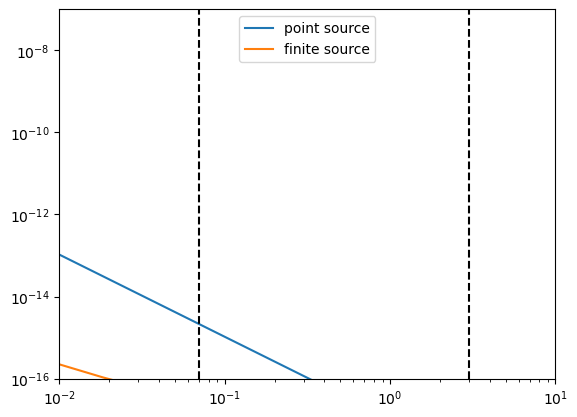

In [18]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')

# Add lines for HSC sensitivity window
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-16,1e-7)
plt.legend()
plt.show()

In [19]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [20]:
ti = 0.07
tf = 3
dnds = quad(diff_rate_interp, ti, tf)[0]

In [21]:
s.n_sources*efficiency*dnds

9.185965970098327e-09

In [38]:
def get_n_events(alpha=2, finite=False):
    s.add_ffp(alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

# def get_n_events_parallel(alpha=2, finite=False):
#     with Pool() as p:
#         results = list(tqdm(p.imap(get_n_events, mass_arr), total=len(mass_arr)))
#     return results

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

In [24]:
n_events = get_n_events(alpha=alpha, finite=False)

In [25]:
n_events_finite = get_n_events(alpha=alpha, finite=True)

In [39]:
n_events

6.430176179068828e-08

## 2D exclusion plots

In [41]:
def get_n_events(A, alpha=2, finite=False):
    #Now A is number of FFPs per star
    s.add_ffp(alpha)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, alpha=2, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, alpha=alpha, finite=finite)
        results = list(p.imap(f, As))
    return results

In [42]:
A_min = 1
A_max = 1e8
alpha_min = 1.1
alpha_max = 2.5
num_points = 20
A_values = np.logspace(np.log10(A_min), np.log10(A_max), num_points)
alpha_values = np.linspace(alpha_min, alpha_max, num_points) 
A_grid, alpha_grid = np.meshgrid(A_values, alpha_values)

get_n_events_values = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=False)
    

100%|██████████| 20/20 [36:12<00:00, 108.64s/it]


In [65]:
get_n_events_values_finite = np.empty_like(A_grid)

for i in tqdm(range(len(alpha_values))):
    get_n_events_values_finite[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
n_events_interp = interp2d(A_values, alpha_values, get_n_events_values, kind='cubic')

In [44]:
A_values_dense = np.logspace(np.log10(A_min), np.log10(A_max), num_points*10)
alpha_values_dense = np.linspace(alpha_min, alpha_max, num_points*10) 
n_events_interp_dense = n_events_interp(A_values_dense, alpha_values_dense)

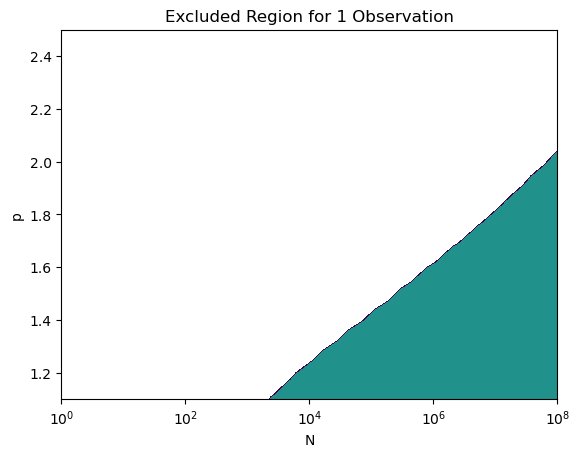

In [48]:
plt.figure()
contour = plt.contourf(A_grid, alpha_grid, get_n_events_values, levels=[4.49, 4.74, 1e10])
# contour = plt.contourf(A_values_dense, alpha_values_dense, n_events_interp_dense, levels=[4.49, 4.74, 1e10])
# plt.colorbar(contour)
plt.xscale('log')
plt.title('Excluded Region for 1 Observation')
plt.xlabel('N')
plt.ylabel('p')
# plt.xlim(1e5,1e7)
# plt.ylim(1.1,2.5)
plt.show()

In [ ]:
plt.figure()
contour = plt.contourf(A_grid, alpha_grid, get_n_events_values_finite, levels=[4.49, 4.74, 1e10])
# contour = plt.contourf(A_values_dense, alpha_values_dense, n_events_interp_dense, levels=[4.49, 4.74, 1e10])
# plt.colorbar(contour)
plt.xscale('log')
plt.title('Excluded Region for 1 Observation, Finite Source')
plt.xlabel('N')
plt.ylabel('p')
# plt.xlim(1e5,1e7)
# plt.ylim(1.1,2.5)
plt.show()

In [58]:
def get_constraint_iso(m_iso, A, alpha=2, finite=False):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    #Number of total events assuming 1 ISO per star
    #Note A doesn't matter for this part of the calculation since it cancels out
    n_events = get_n_events(A, alpha=alpha, finite=finite)/A

    #Porportion of ISOs above threshold
    #! This is assuming all objects are detectable, which they aren't. Need proportion of DETECTABLE objects above threshold
    proportion_above_threshold = nquad(s.ffp.mass_func,[[m_iso, s.ffp.m_max]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3]})[0]*s.ffp.Z

    #Maximum number of allowed ISOs per star of mass m_iso
    return 4.74/n_events * proportion_above_threshold    

In [59]:
get_constraint_iso(1e-9, 1e6, alpha=2, finite=False)

73.70756054712474

In [60]:
get_constraint_iso(1e-9, 1e6, alpha=1.5, finite=False)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


275.44835948657914

In [61]:
get_constraint_iso(1e-11, 1e6, alpha=2, finite=False)

7371.485832539678

In [62]:
#A shouldn't matter. It should cancel out
get_constraint_iso(1e-11, 1e2, alpha=2, finite=False)

7371.48583253968

In [63]:
get_constraint_iso(3e-6, 1e6, alpha=2, finite=False)

0.01720015080941005

In [52]:
def max_objects_above_threshold(m_threshold, A, alpha):
    # Calculate the total number of objects using get_n_events
    total_objects = get_n_events(A, alpha)
    print("Total objects: ", total_objects)

    # Calculate the proportion of objects with masses greater than m_threshold
    proportion_above_threshold = (1e-15 / m_threshold) ** alpha
    print("Proportion above threshold: ", proportion_above_threshold)

    # Calculate the expected number of ISOs with masses greater than m_threshold
    objects_above_threshold = total_objects * proportion_above_threshold 

    return objects_above_threshold

In [53]:
max_objects_above_threshold(1e-9,1e6,1.2)

Total objects:  686.4597912090942
Proportion above threshold:  6.309573444801936e-08


4.3312684695371826e-05

In [51]:
(1e-15 / 1e-9) ** alpha

1e-12

In [ ]:
?rho_FFPs_mw()

In [161]:
confidence_level_threshold = 0.05

Nexp = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

The 95% C.L. is reached when Nexp <= 4.499999999999948
